<br>
# Battle of The Neighbourhoods  

## DBSCAN and K-means Clustering for Desirable Living Locale
<br><br><br>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#import">Import Libraries</a>  

2. <a href="#postload">Loading Ottawa Postal Codes</a>  

3. <a href="#postcoord">Postal Code Coordinates</a>  

4. <a href="#crime">Ottawa Crime Dataset</a>  

5. <a href="#dbscan">DBSCAN Clustering</a>  

6. <a href="#foursquare">Foursquare Data Retrieval</a>  

7. <a href="#kmeans">K-means Clustering</a>  

8. <a href="#cluster">Examine Clusters</a>    
</font>
</div>

## Import Libraries
<div id="import">
</div>

In [319]:
import numpy as np # library to handle data in a vectorized manner
import folium
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

## Loading Ottawa Postal Codes 
<div id="postload">
The codes below were sourced from the Ottawa Police Department, and were entered into a dataframe. 
(data: https://www.ottawapolice.ca/en/contact-us/resources/ottawa-postal-codes.pdf)
<br\>
<br>
</div>

In [320]:
pcodes = {'PostalCode': ['K1A', 'K2A','K4A', \
                          'K1B','K2B','K4B', \
                          'K1C','K2C','K4C', \
                          'K1E','K2E','K1G', \
                          'K2G','K1H','K2H', \
                          'K1J','K2J','K1K', \
                          'K2K','K1L','K2L', \
                          'K1M','K2M','K2M', \
                          'K1N','K1P','K2P', \
                          'K4P','K1R','K2R', \
                          'K1S','K2S','K1T', \
                          'K2T','K1V','K2V', \
                          'K1W','K2W','K1X', \
                          'K1Y','K1Z'], \
        'Neighbourhood': ['Government of Canada', 'Highland Park, Mckelllar Park, Westboro, Glabar Park, Carlingwood','Fallingbrook', \
                          'Blackburn Hamlet, Pine View, Sheffield Glen','Britannia, Whitehaven, Bayshore, Pinecrest','Cumberland Ward', \
                          'Orleans','Queensway, Copeland Park, Central Park, Bel Air, Carleton Heights','Cumberland', \
                          'Queenswood','Eastern Nepean, Fisher Heights, Parkwood Hills, Borden Farm, Pine Glen','Riverview, Hawthorne, Canterbury, Hunt Club Park', \
                          'Centrepointe, Meadowlands, City View, Craig Henry, Tangelwood, Grenfell Glen, Davidson Heights','Alta Vista, Billings Bridge','Bells Corners, Arlington Woods, Redwood, Qualicum, Crystal Beach', \
                          'Beacon Hill, Cyrville, Carson Grove','Barrhaven','Overbrook, Forbes, Manor Park, Viscount Alexander Park, Finter Quarries', \
                          'Beaverbrook, South March','Vanier, McKay Lake','Katimavik-Hazeldean, Glen Cairn', \
                          'Rockcliffe Park, New Edinburgh','Bridlewood','Manotick', \
                          'Lower Town, Byward Market, Sandy Hill, University of Ottawa','Parliament Hill','Centretown', \
                          'Greely','Dalhousie Ward','Fallowfield Village, Cedarhill Estates, Orchard Estates', \
                          'The Glebe, Old Ottawa South, Old Ottawa East, Carleton University, Dow\'s Lake Area', 'Stittsville','Blossom Park, Greenboro, Leitrim, Findlay Creek', \
                          'Marchwood','Heron Gate, Heron Park, Riverside Park, Hunt Club, Riverside South, Airport','Terry Fox, Palladium', \
                          'Chapel Hill South, Blackburn','North March','South Gloucester', \
                          'Civic Hospital, Island Park, Hintonburg, Mechanicsville, Champlain Park','Westboro, Carlington']}


pcodes_df = pd.DataFrame(pcodes)
pcodes_df.head()


,PostalCode,Neighbourhood
0,K1A,Government of Canada
1,K2A,"Highland Park, Mckelllar Park, Westboro, Glaba..."
2,K4A,Fallingbrook
3,K1B,"Blackburn Hamlet, Pine View, Sheffield Glen"
4,K2B,"Britannia, Whitehaven, Bayshore, Pinecrest"


<br>
<br>
<br>
## Postal Code Coordinates  
<div id="postcoord">
This was done utilizing the "pypostalcode" library, due to containing data regarding common Canadian postal codes.
<br/>
<br>
</div>

In [321]:
from pypostalcode import PostalCodeDatabase
pcdb = PostalCodeDatabase()

lat_ar = np.zeros(pcodes_df.shape[0])
lon_ar = np.zeros(pcodes_df.shape[0])

for i in range(pcodes_df.shape[0]):
    lat_ar[i] = pcdb[pcodes_df.PostalCode[i]].latitude
    lon_ar[i] = pcdb[pcodes_df.PostalCode[i]].longitude

pcodes_df['Latitude'] = lat_ar
pcodes_df['Longitude'] = lon_ar

pcodes_df.head(8)


,PostalCode,Neighbourhood,Latitude,Longitude
0,K1A,Government of Canada,45.4207,-75.7023
1,K2A,"Highland Park, Mckelllar Park, Westboro, Glaba...",45.3778,-75.7632
2,K4A,Fallingbrook,45.4769,-75.4835
3,K1B,"Blackburn Hamlet, Pine View, Sheffield Glen",45.4325,-75.5624
4,K2B,"Britannia, Whitehaven, Bayshore, Pinecrest",45.3679,-75.7888
5,K4B,Cumberland Ward,45.4251,-75.4288
6,K1C,Orleans,45.4805,-75.5237
7,K2C,"Queensway, Copeland Park, Central Park, Bel Ai...",45.3594,-75.7523


<br>
<br>
<br>
## Ottawa Crime Dataset  
<div id="crime">
Incident reports were loaded into the dataframe below using data from Carleton University, (data: https://library.carleton.ca/find/gis/geospatial-data/ottawa-police-service-crime-data).  
Specifcally, crimes against persons during 2015 was the chosen dataset. 
<br/>
<br>
</div>

In [322]:
crime_df = pd.read_excel('opscriminalcodeoffences20112015.xlsx', sheet_name="CPerson 2015")
crime_df.drop([0],inplace=True)
crime_df = crime_df.query('PostalCode != 0').reset_index(drop=True)
crime_df.head()

,ONS,PostalCode,Abduction,Assaults,Attempted_Murder,Homicide_Incidents,Other_Offences,Robbery,Sexual_Violations,Uttering_Threats_or_Intimidation,Grand_Total
0,Barrhaven,K2J,1,15,0,0,1,4,2,4,27
1,Bayshore,K2B,1,22,0,0,5,1,5,5,39
2,Beacon Hill South - Cardinal Heights,K1J,0,12,1,2,7,11,6,2,41
3,Beaverbrook,K2K,1,9,0,0,3,4,4,2,23
4,Bells Corners East,K2H,0,16,0,0,7,1,4,0,28


<br>
<br>
Neighbourhoods were then grouped by postal code, with grouped values being summed. 
<br/>
<br>

In [403]:
crime_sum = crime_df.groupby('PostalCode').sum()
crime_sum['PostalCode'] = crime_test.index
crime_sum

,Abduction,Assaults,Attempted_Murder,Homicide_Incidents,Other_Offences,Robbery,Sexual_Violations,Uttering_Threats_or_Intimidation,Grand_Total,PostalCode
PostalCode,,,,,,,,,,
K1B,2,51,0,0,12,9,9,7,90,K1B
K1C,5,150,0,1,77,19,47,20,319,K1C
K1G,2,61,0,1,22,16,14,17,133,K1G
K1H,1,19,0,0,8,10,8,6,52,K1H
K1J,2,41,2,2,22,15,16,7,107,K1J
K1K,3,110,0,0,27,31,15,23,209,K1K
K1L,5,144,2,1,23,35,22,18,250,K1L
K1M,0,15,0,0,7,3,6,1,32,K1M
K1N,5,385,0,0,40,69,52,54,605,K1N


<br>
<br>
The postal code and summed crime dataframes were merged on postal code values.
<br/>
<br>

In [404]:
ottawa_df = pd.merge(pcodes_df, crime_sum, on='PostalCode', how='inner')
ottawa_df

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 'PostalCode' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,PostalCode,Neighbourhood,Latitude,Longitude,Abduction,Assaults,Attempted_Murder,Homicide_Incidents,Other_Offences,Robbery,Sexual_Violations,Uttering_Threats_or_Intimidation,Grand_Total
0,K2A,"Highland Park, Mckelllar Park, Westboro, Glaba...",45.3778,-75.7632,1,15,0,0,1,1,4,1,23
1,K1B,"Blackburn Hamlet, Pine View, Sheffield Glen",45.4325,-75.5624,2,51,0,0,12,9,9,7,90
2,K2B,"Britannia, Whitehaven, Bayshore, Pinecrest",45.3679,-75.7888,2,89,2,0,21,7,24,18,163
3,K1C,Orleans,45.4805,-75.5237,5,150,0,1,77,19,47,20,319
4,K2C,"Queensway, Copeland Park, Central Park, Bel Ai...",45.3594,-75.7523,3,30,0,0,16,13,2,3,67
5,K4C,Cumberland,45.5177,-75.4108,0,3,0,0,1,0,3,0,7
6,K2E,"Eastern Nepean, Fisher Heights, Parkwood Hills...",45.3353,-75.7209,0,47,0,0,8,12,13,9,89
7,K1G,"Riverview, Hawthorne, Canterbury, Hunt Club Park",45.4118,-75.6304,2,61,0,1,22,16,14,17,133
8,K2G,"Centrepointe, Meadowlands, City View, Craig He...",45.3286,-75.7703,4,75,1,0,23,14,18,17,152
9,K1H,"Alta Vista, Billings Bridge",45.3938,-75.6639,1,19,0,0,8,10,8,6,52


<br>
<br>
Upon inspection, coordinate values were to be corrected for neighbourhoods 'Byward Market' and 'Manotick' (due to errors in the "pypostalcode" library).
<br/>
<br>

In [405]:
#Coordinates to be corrected!
pc1 = ottawa_df[ottawa_df['Neighbourhood'].str.contains('Byward')] #lat = 45.4265, lon = -75.6848
pc2 = ottawa_df[ottawa_df['Neighbourhood'].str.contains('Manotick')] #lat = 45.2275, lon = -75.7229
pc3 = ottawa_df[ottawa_df['Neighbourhood'].str.contains('The Glebe')] #lat = 45.3944, lon = -75.6955

ottawa_df.at[pc1.index,'Latitude'] = 45.4265
ottawa_df.at[pc1.index,'Longitude'] = -75.6848

ottawa_df.at[pc2.index,'Latitude'] = 45.2275
ottawa_df.at[pc2.index,'Longitude'] = -75.7229

ottawa_df.at[pc3.index,'Latitude'] = 45.3944
ottawa_df.at[pc3.index,'Longitude'] = -75.6955

In [406]:
# create map of Ottawa using latitude and longitude values
map_ottawa = folium.Map(location=[45.4215, -75.6972], zoom_start=12)
scale = ottawa_df['Grand_Total'].min()/ottawa_df['Grand_Total'].max()
# add markers to map
for lat, lng, label, total in zip(ottawa_df['Latitude'], ottawa_df['Longitude'], ottawa_df['Neighbourhood'],ottawa_df['Grand_Total']):
    label = folium.Popup(label+'\n'+'-- Grand Total = {}'.format(total), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        #parse_html=False
        ).add_to(map_ottawa)  
    
map_ottawa

<br>
<br>
## DBSCAN Crime Clustering
<div id="dbscan">
<br>
</div>
</br>

In [407]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = ottawa_df[['Latitude','Longitude','Grand_Total']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.75, min_samples=2).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
ottawa_df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
ottawa_df[['Latitude','Longitude','Grand_Total',"Clus_Db"]].head()

,Latitude,Longitude,Grand_Total,Clus_Db
0,45.3778,-75.7632,23,0
1,45.4325,-75.5624,90,1
2,45.3679,-75.7888,163,0
3,45.4805,-75.5237,319,-1
4,45.3594,-75.7523,67,0


In [458]:
# create map of Ottawa using latitude and longitude values
map_ottawa = folium.Map(location=[45.4215, -75.6972], zoom_start=12)
scale = ottawa_df['Grand_Total'].min()/ottawa_df['Grand_Total'].max()
# add markers to map
for lat, lng, label, total, clust in zip(ottawa_df['Latitude'], ottawa_df['Longitude'], ottawa_df['Neighbourhood'],ottawa_df['Grand_Total'],ottawa_df['Clus_Db']):
    label = folium.Popup(label+'\n'+'-- Grand Total = {}, Cluster {}'.format(total, clust), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6*scale*total,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7,
        #parse_html=False
        ).add_to(map_ottawa)  

folium.Marker([45.3876, -75.6960], popup='Carleton University',icon=folium.Icon(color='red')).add_to(map_ottawa)
folium.Marker([45.4231, -75.6831], popup='University of Ottawa',icon=folium.Icon(color='blue')).add_to(map_ottawa)
folium.Marker([45.3483, -75.7562], popup='Algonquin College',icon=folium.Icon(color='green')).add_to(map_ottawa)

map_ottawa

<br>
### University of Ottawa - DBSCAN Cluster

In [464]:
ottawa_db = ottawa_df
ottawa_db = ottawa_db[['Neighbourhood','Assaults','Sexual_Violations','Robbery','Grand_Total','Clus_Db']]

ottawa_db.loc[ottawa_db['Clus_Db'] == 3, \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Assaults,Sexual_Violations,Robbery,Grand_Total,Clus_Db
20,"Lower Town, Byward Market, Sandy Hill, Univers...",385,52,69,605,3
21,Centretown,310,72,60,593,3


<br>
### Carleton University - DBSCAN Cluster

In [465]:
ottawa_db = ottawa_db[['Neighbourhood','Assaults','Sexual_Violations','Robbery','Grand_Total','Clus_Db']]

ottawa_db.loc[ottawa_db['Clus_Db'] == 0, \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Assaults,Sexual_Violations,Robbery,Grand_Total,Clus_Db
23,"The Glebe, Old Ottawa South, Old Ottawa East, ...",120,57,23,255,0
30,"Westboro, Carlington",106,17,15,184,0
29,"Civic Hospital, Island Park, Hintonburg, Mecha...",106,15,11,167,0
2,"Britannia, Whitehaven, Bayshore, Pinecrest",89,24,7,163,0
8,"Centrepointe, Meadowlands, City View, Craig He...",75,18,14,152,0
6,"Eastern Nepean, Fisher Heights, Parkwood Hills...",47,13,12,89,0
4,"Queensway, Copeland Park, Central Park, Bel Ai...",30,2,13,67,0
0,"Highland Park, Mckelllar Park, Westboro, Glaba...",15,4,1,23,0


<br>
### Eastern Ottawa - DBSCAN Cluster

In [467]:
ottawa_db = ottawa_db[['Neighbourhood','Assaults','Sexual_Violations','Robbery','Grand_Total','Clus_Db']]

ottawa_db.loc[ottawa_db['Clus_Db'] == 1, \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Assaults,Sexual_Violations,Robbery,Grand_Total,Clus_Db
15,"Vanier, McKay Lake",144,22,35,250,1
13,"Overbrook, Forbes, Manor Park, Viscount Alexan...",110,15,31,209,1
7,"Riverview, Hawthorne, Canterbury, Hunt Club Park",61,14,16,133,1
11,"Beacon Hill, Cyrville, Carson Grove",41,16,15,107,1
1,"Blackburn Hamlet, Pine View, Sheffield Glen",51,9,9,90,1
9,"Alta Vista, Billings Bridge",19,8,10,52,1
28,"Chapel Hill South, Blackburn",16,5,5,38,1
25,"Blossom Park, Greenboro, Leitrim, Findlay Creek",17,3,2,34,1
17,"Rockcliffe Park, New Edinburgh",15,6,3,32,1


<br>
<br>
## Foursquare Data Retrieval  
<div id="foursquare">
Foursquare API credentials were loaded and applied to retrieve venues for each neighbourhood.
<br/>
<br>
</div>

In [409]:
CLIENT_ID = 'TV5BVZSB03SVCXXIQCBUL2JC3TJQB2KETJ5IJKRKXEIJEL2D' # your Foursquare ID
CLIENT_SECRET = 'CZDFS34WOTNSSXCT5C5QOBKHMRD2G0RRQTWHGDQ2DOP2EW4O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1200 # define radius

In [410]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,             
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [411]:
ottawa_venues = getNearbyVenues(names=ottawa_df['Neighbourhood'],
                                   latitudes=ottawa_df['Latitude'],
                                   longitudes=ottawa_df['Longitude']
                                  )

Highland Park, Mckelllar Park, Westboro, Glabar Park, Carlingwood
Blackburn Hamlet, Pine View, Sheffield Glen
Britannia, Whitehaven, Bayshore, Pinecrest
Orleans
Queensway, Copeland Park, Central Park, Bel Air, Carleton Heights
Cumberland
Eastern Nepean, Fisher Heights, Parkwood Hills, Borden Farm, Pine Glen
Riverview, Hawthorne, Canterbury, Hunt Club Park
Centrepointe, Meadowlands, City View, Craig Henry, Tangelwood, Grenfell Glen, Davidson Heights
Alta Vista, Billings Bridge
Bells Corners, Arlington Woods, Redwood, Qualicum, Crystal Beach
Beacon Hill, Cyrville, Carson Grove
Barrhaven
Overbrook, Forbes, Manor Park, Viscount Alexander Park, Finter Quarries
Beaverbrook, South March
Vanier, McKay Lake
Katimavik-Hazeldean, Glen Cairn
Rockcliffe Park, New Edinburgh
Bridlewood
Manotick
Lower Town, Byward Market, Sandy Hill, University of Ottawa
Centretown
Greely
The Glebe, Old Ottawa South, Old Ottawa East, Carleton University, Dow's Lake Area
Stittsville
Blossom Park, Greenboro, Leitrim, Fi

In [412]:
unique, counts = np.unique(ottawa_venues['Neighbourhood'].values, return_counts=True)
ottawa_venues.shape
len(unique)

30

<br>
<br>
The most common venues for each neighbourhood are classified.
<br/>
<br>

In [413]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [414]:
# one hot encoding
ottawa_onehot = pd.get_dummies(ottawa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ottawa_onehot['Neighbourhood'] = ottawa_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [ottawa_onehot.columns[-1]] + list(ottawa_onehot.columns[:-1])
ottawa_onehot = ottawa_onehot[fixed_columns]

ottawa_grouped = ottawa_onehot.groupby('Neighbourhood').mean().reset_index()

In [415]:
#Group by top 5 venues only
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = ottawa_grouped['Neighbourhood']

for ind in np.arange(ottawa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ottawa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(30, 6)

In [416]:
ottawa_grouped.head()

,Neighbourhood,Adult Boutique,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Big Box Store,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Laser Tag,Laundry Service,Library,Liquor Store,Lounge,Luggage Store,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Record Shop,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Alta Vista, Billings Bridge",0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.090909,0.272727,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Barrhaven,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0

<br>
<br>
## K-means Clustering
<div id="kmeans">
Neighbourhoods are clustered according to nearby venues, and overlayed alongside the crime distribution map.
<br/>
<br>
</div>

In [417]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl

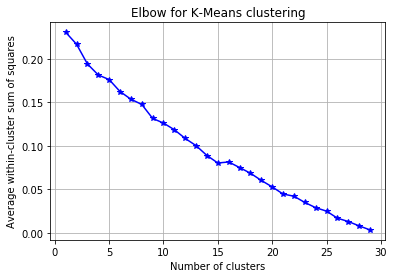

In [418]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

K = range(1,30)

  # scipy.cluster.vq.kmeans
KM = [kmeans(ottawa_grouped_clustering,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(ottawa_grouped_clustering, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/ottawa_grouped_clustering.shape[0] for d in dist] 

kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

In [429]:
# set number of clusters
kclusters = 5

ottawa_grouped_clustering = ottawa_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(init='random',n_init=50,n_clusters=kclusters, random_state=0).fit(ottawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
len(kmeans.labels_)

30

In [430]:
#Initialize dataframe with filtered neighbourhood data
ottawa_merged = pd.merge(ottawa_df,neighborhoods_venues_sorted, on='Neighbourhood', how='inner')

# add clustering labels
ottawa_merged['Cluster Labels'] = kmeans.labels_

ottawa_merged.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Abduction,Assaults,Attempted_Murder,Homicide_Incidents,Other_Offences,Robbery,Sexual_Violations,Uttering_Threats_or_Intimidation,Grand_Total,Clus_Db,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,K2A,"Highland Park, Mckelllar Park, Westboro, Glaba...",45.3778,-75.7632,1,15,0,0,1,1,4,1,23,0,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Diner,4
1,K1B,"Blackburn Hamlet, Pine View, Sheffield Glen",45.4325,-75.5624,2,51,0,0,12,9,9,7,90,1,Convenience Store,Sandwich Place,Pharmacy,Coffee Shop,Skating Rink,3
2,K2B,"Britannia, Whitehaven, Bayshore, Pinecrest",45.3679,-75.7888,2,89,2,0,21,7,24,18,163,0,Fast Food Restaurant,Sandwich Place,Grocery Store,Italian Restaurant,Pharmacy,2
3,K1C,Orleans,45.4805,-75.5237,5,150,0,1,77,19,47,20,319,-1,Coffee Shop,Fast Food Restaurant,Sporting Goods Shop,Sandwich Place,Gym,2
4,K2C,"Queensway, Copeland Park, Central Park, Bel Ai...",45.3594,-75.7523,3,30,0,0,16,13,2,3,67,0,Coffee Shop,Grocery Store,Restaurant,Diner,Shopping Mall,2


In [440]:
# create map
map_clusters = folium.Map(location=[45.4215, -75.6972], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, total in zip(ottawa_merged['Latitude'], ottawa_merged['Longitude'], ottawa_merged['Neighbourhood'], ottawa_merged['Cluster Labels'], ottawa_merged['Grand_Total']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+'\n'+'-- Grand Total = {}'.format(total), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5*scale*total,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    

folium.Marker([45.3876, -75.6960], popup='Carleton University',icon=folium.Icon(color='red')).add_to(map_clusters)
folium.Marker([45.4231, -75.6831], popup='University of Ottawa',icon=folium.Icon(color='blue')).add_to(map_clusters)
folium.Marker([45.3483, -75.7562], popup='Algonquin College',icon=folium.Icon(color='green')).add_to(map_clusters)
       
map_clusters

<br>
<br>
## Cluster Analysis

<div id="cluster">
</br>
<br>
</div>

### University of Ottawa - Cluster 2
<br><br>
The primary venue cluster of Ottawa, cluster 2 is dominated by coffee shops, parks, cafes, and various cuisines. Due to the proximity of this cluster to the city center, and the associated crime level, students will need to be aware when commuting to the University of Ottawa if in this cluster.

In [434]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 2, \
                  ottawa_merged.columns[[1] + list(range(12, ottawa_merged.shape[1]))] \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Grand_Total,Clus_Db,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
19,"Lower Town, Byward Market, Sandy Hill, Univers...",605,3,Coffee Shop,Café,Hotel,Restaurant,Park,2
20,Centretown,593,3,Coffee Shop,Café,Restaurant,Vegetarian / Vegan Restaurant,Concert Hall,2
3,Orleans,319,-1,Coffee Shop,Fast Food Restaurant,Sporting Goods Shop,Sandwich Place,Gym,2
29,"Westboro, Carlington",184,0,Italian Restaurant,Coffee Shop,Sporting Goods Shop,Tapas Restaurant,Pharmacy,2
2,"Britannia, Whitehaven, Bayshore, Pinecrest",163,0,Fast Food Restaurant,Sandwich Place,Grocery Store,Italian Restaurant,Pharmacy,2
10,"Bells Corners, Arlington Woods, Redwood, Quali...",74,2,Grocery Store,Fast Food Restaurant,Italian Restaurant,Electronics Store,Sandwich Place,2
4,"Queensway, Copeland Park, Central Park, Bel Ai...",67,0,Coffee Shop,Grocery Store,Restaurant,Diner,Shopping Mall,2
25,Marchwood,64,2,Electronics Store,Pizza Place,Coffee Shop,Toy / Game Store,Sandwich Place,2
23,Stittsville,60,2,Pizza Place,Bridal Shop,Park,Playground,Coffee Shop,2
9,"Alta Vista, Billings Bridge",52,1,Bus Station,Hookah Bar,Burger Joint,Bus Line,Pizza Place,2


<br><br>
### Carleton University - Cluster 3
<br><br>
The secondary venue cluster of Ottawa, cluster 3 shares similar tastes to its larger counterpart. However, the spread and distance of this cluster from the city center corresponds to a lower crime level.  hence students commuting to and from Carleton University or Algonquin College may elect to choose a residence nearby the campus.

In [435]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 3, \
                  ottawa_merged.columns[[1] + list(range(12, ottawa_merged.shape[1]))] \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Grand_Total,Clus_Db,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
22,"The Glebe, Old Ottawa South, Old Ottawa East, ...",255,0,Coffee Shop,Pub,Bakery,Park,Diner,3
28,"Civic Hospital, Island Park, Hintonburg, Mecha...",167,0,Coffee Shop,Italian Restaurant,Bakery,Sandwich Place,Tapas Restaurant,3
8,"Centrepointe, Meadowlands, City View, Craig He...",152,0,Snack Place,Shopping Mall,Supermarket,Pool Hall,Sandwich Place,3
16,"Katimavik-Hazeldean, Glen Cairn",130,2,Pharmacy,Coffee Shop,Bus Station,Supermarket,Seafood Restaurant,3
11,"Beacon Hill, Cyrville, Carson Grove",107,1,Fast Food Restaurant,Coffee Shop,Toy / Game Store,Bakery,Sandwich Place,3
1,"Blackburn Hamlet, Pine View, Sheffield Glen",90,1,Convenience Store,Sandwich Place,Pharmacy,Coffee Shop,Skating Rink,3
6,"Eastern Nepean, Fisher Heights, Parkwood Hills...",89,0,Coffee Shop,Hardware Store,Gym,Furniture / Home Store,Mini Golf,3


<br><br>
### Eastern Ottawa - Cluster 0
<br><br>
The last notable cluster, Eastern Ottawa comprises districts notable for Indian cuisine, clothing stores, and coffee shops. Potential residents should note comparably high crime levels when compared to the Carleton University cluster; therefore Eastern Ottawa may pose a similar, if not greater risk than the Carleton cluster.

In [436]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 0, \
                  ottawa_merged.columns[[1] + list(range(12, ottawa_merged.shape[1]))] \
                 ].sort_values(by='Grand_Total',ascending=False)

,Neighbourhood,Grand_Total,Clus_Db,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
26,"Heron Gate, Heron Park, Riverside Park, Hunt C...",379,-1,Grocery Store,Coffee Shop,Clothing Store,Department Store,Fast Food Restaurant,0
13,"Overbrook, Forbes, Manor Park, Viscount Alexan...",209,1,Pizza Place,Fast Food Restaurant,Grocery Store,Coffee Shop,Indian Restaurant,0
7,"Riverview, Hawthorne, Canterbury, Hunt Club Park",133,1,Coffee Shop,Grocery Store,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,0
